In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Analisis Sentimen dengan TF-IDF

Text Classification adalah proses klasifikasi data dalam bentuk teks seperti tweet, review, artikel, dan blog, ke dalam kategori yang telah ditentukan. Analisis Sentimen adalah special case dari Text Classification, yaitu di mana pendapat atau sentimen pengguna tentang produk apa pun dapat diprediksi dari data tekstual.

Dalam tutorial ini, Kita akan belajar mengembangkan model Analisis Sentimen yang akan menggunakan pendekatan pada pembuatan fitur TF-IDF dan akan mampu memprediksi sentimen pengguna (yaitu pandangan atau pendapat yang dimiliki atau diungkapkan) tentang 6 Maskapai Penerbangan yang beroperasi di Amerika Serikat dengan menganalisis melalui tweet pengguna twitter. Kita akan menggunakan salah satu library Python untuk machine learning yaitu Scikit-Learn, Untuk mengimplementasikan penggunaan dari fitur TF-IDF dan melatih prediction model.

## Melakukan Import Library

In [ ]:
import numpy as np 
import pandas as pd 
import re  
import nltk 
nltk.download('stopwords')  
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Dataset

Gunakan metode read_csv dari library Pandas untuk memuat dataset ke dalam kerangka data "tweets" (*). Anda dapat menggunakan URL online atau mengunduh file dan menggunakan jalur lokal file CSV di mesin Anda.

Langkah selanjutnya, muat dataset yang akan digunakan untuk melatih model. Seperti yang kita bicarakan sebelumnya, Kita akan membangun model analisis sentimen untuk memprediksi sentimen publik tentang 6 maskapai besar yang beroperasi di Amerika Serikat. Dataset tersedia secara bebas di tautan Github ini. Sentimen yang digunakan yaitu hanya positive dan negative.

Gunakan metode read_csv dari library Pandas untuk memuat dataset ke dalam dataframe “tweets”. Kita dapat menggunakan URL online atau mengunduh file dan menggunakan lokal path file CSV di drive.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/rasyidev/well-known-datasets/main/Tweets.csv")

t_1 = data[data['airline_sentiment']=='positive']#.sample(100,replace=True)
t_2 = data[data['airline_sentiment']=='negative']#.sample(400,replace=True)
tweets = pd.concat([t_1, t_2])

(*) DataFrame adalah struktur data dua dimensi, sehingga data diselaraskan dalam bentuk seperti tabel, yaitu dalam baris dan kolom. Ini umumnya merupakan objek dari Pandas yang paling umum digunakan.

Untuk melihat bagaimana dataset terlihat, gunakan metode head() dari dataframe Pandas, yang akan menampilkan 5 baris pertama atau metode tail() untuk menampilkan 5 baris terbawah dari dataset seperti yang ditunjukkan di bawah ini:

In [ ]:
# Cek 5 Dataset teratas
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)
11,570289724453216256,positive,1.0000,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York


In [ ]:
# Cek 5 Dataset terbawah
tweets.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14631,569588464896876545,negative,1.0000,Bad Flight,1.0000,American,NaN,MDDavis7,NaN,0,@AmericanAir thx for nothing on getting us out...,NaN,2015-02-22 12:04:07 -0800,US,Eastern Time (US & Canada)
14633,569587705937600512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,2015-02-22 12:01:06 -0800,Los Angeles,Arizona
14634,569587691626622976,negative,0.6684,Late Flight,0.6684,American,NaN,GolfWithWoody,NaN,0,@AmericanAir right on cue with the delays👌,NaN,2015-02-22 12:01:02 -0800,NaN,Quito
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


Begitu pula untuk menampilkan atau menemukan jumlah baris dan kolom dalam dataset, Anda dapat menggunakan atribut  columns dan shape seperti yang ditunjukkan di bawah ini:

In [ ]:
# Cek attribut dataset
display(tweets.columns)

# Cek jumlah baris dan kolom dataset
display(tweets.shape)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

(11541, 15)

Dalam output, Kita melihat ada (11541, 15) yang berarti bahwa dataset kami terdiri dari 11541 baris dan 15 kolom. Namun, di antara kolom, kita hanya tertarik pada kolom “airline_sentiment” yang terdiri dari kategori sentimen sebenarnya, dan kolom “text” yang berisi teks aktual dari tweet tersebut.

## Explorasi Data

Jadi, sebelum kita membangun model yang sebenarnya. Mari kita lakukan beberapa eksplorasi analisis data pada model. Untuk melihat jumlah ulasan positif dan negatif dalam bentuk plot bar, jalankan skrip dibawah di mana library python dari Seaborn digunakan untuk menggambar metode countplot.

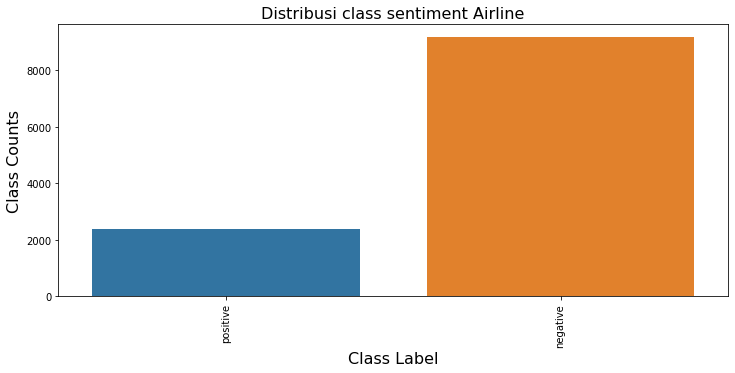

In [ ]:
# Cek jumlah review positive dan negative
plt.figure(figsize=(12,5))
sns.countplot(x='airline_sentiment', data=tweets)
plt.title('Distribusi class sentiment Airline', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

Dari output, Kita dapat melihat bahwa jumlah ulasan negatif jauh lebih tinggi daripada jumlah ulasan positif dan netral.

Demikian pula untuk melihat maskapai mana yang mendapat ulasan tertinggi, jalankan skrip berikut.

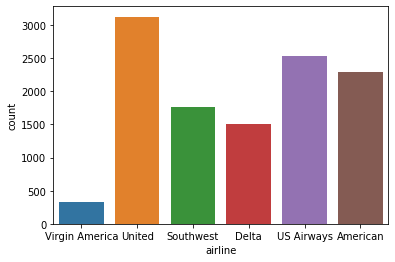

In [ ]:
# Cek Airline yang mendapat review paling tinggi
sns.countplot(x='airline', data=tweets);

Dari output, Kita dapat melihat bahwa Maskapai Penerbangan “United” mendapat jumlah ulasan tertinggi sedangkan “Virgin America” mendapat jumlah ulasan terendah.

Akhirnya, mari kita lihat jumlah review dari setiap jenis yang diterima setiap maskapai. Untuk melakukannya, kita dapat kembali menggunakan metode countplot dari library seaborn.

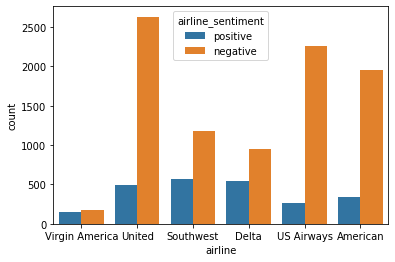

In [ ]:
# Cek jumlah review dari masing-masing Airline yang diterima
sns.countplot(x='airline', hue="airline_sentiment", data=tweets);

Kita dapat melihat bahwa untuk hampir semua maskapai, jumlah ulasan negatif lebih besar daripada ulasan positif dan netral.

Cukup untuk bagian analisis data eksplorasi, mari kita pindah ke bagian pemrosesan data.

## Pemrosesan Data

Pertama, mari kita membagi dataset menjadi feature dan label set. Di feature set, Kita hanya akan menggunakan text tweet sebagai feature. Label yang sesuai akan menjadi sentimen dari tweet tersebut. Kolom text adalah kolom ke 10 (indeks kolom dimulai dari 0 di panda) dalam dataset dan berisi teks dari tweet tersebut. Demikian pula "airline_sentiment" adalah kolom pertama yang berisi sentimen. Gunakan metode "iloc" dari dataframe panda untuk membuat feature set X dan label set y, seperti yang ditunjukkan di bawah ini.

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = tweets.iloc[:, 10].values  
le = LabelEncoder()
le.fit(["positive", "negative"])

print(list(le.classes_))
y = le.transform(tweets.iloc[:, 1].values)

#y = tweets.iloc[:, 1].values
print(X.shape)
print(X[0])
print(y.shape)
print(y[0])

['negative', 'positive']
(11541,)
@VirginAmerica plus you've added commercials to the experience... tacky.
(11541,)
1


Dataset tersebut berisi banyak karakter khusus dan ruang kosong. Kita harus menghapusnya agar memiliki dataset yang bersih. Berikut script untuk melakukan itu:

In [ ]:
# Membuat empty List
processed_tweets = []

for tweet in range(0, len(X)):  
    # Hapus semua special characters
    processed_tweet = re.sub(r'\W', ' ', str(X[tweet]))

    # Hapus semua single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)

    # Hapus single characters dari awal
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 

    # Substitusi multiple spaces dengan single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)

    # Hapus prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)

    # Ubah menjadi Lowercase
    processed_tweet = processed_tweet.lower()

    # Masukkan ke list kosong yang telah dibuat sebelumnya
    processed_tweets.append(processed_tweet)


Mari kita lihat apa yang terjadi dalam skrip di atas. Pada dasarnya terdiri dari berbagai jenis ekspresi reguler untuk melakukan preprocessing teks. Ekspresi reguler `re.sub(r'\W', ' ', str(X[tweet]))` berfungsi untuk menghapus semua karakter khusus dari tweet.

Ketika menghapus karakter khusus, Kita hanya memiliki satu karakter yang tidak memiliki arti. Misalnya, ketika menghapus karakter khusus dari kata "Julia's", Kita dibiarkan "Julia" dan "s". Di sini "s" tidak memiliki arti. Ekspresi reguler `re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)` menghapus semua karakter tunggal kecuali yang ada di awal. Untuk menghapus karakter tunggal dari awal kalimat, digunakan regex `re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet)`.

Selanjutnya yaitu hasil dari menghapus karakter khusus dan spasi tunggal, terdapat beberapa spasi muncul dalam teks. Untuk menghapus beberapa spasi ini dan menggantinya dengan spasi tunggal, gunakan regex `re.sub(r'\s+', ' ', processed_tweet, flags=re.I)`.

Dalam beberapa kasus, dataset memiliki format byte. Dalam kasus seperti itu, karakter "b" ditambahkan di awal string. Hapus "b" yang berada didepan dengan menggunakan regex  `re.sub(r'^b\s+', '', processed_tweet)`. Langkah terakhir yaitu ubah teks menjadi huruf kecil untuk menjaga keseragaman.

In [ ]:
# Cek sebelum cleaning data
print(str(X[:5]))
print()

# Cek setelah cleaning data
processed_tweets[:5]

["@VirginAmerica plus you've added commercials to the experience... tacky."
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)'
 "@virginamerica Well, I didn't…but NOW I DO! :-D"
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D']



[' virginamerica plus you ve added commercials to the experience tacky ',
 ' virginamerica yes nearly every time fly vx this ear worm won go away ',
 ' virginamerica well didn but now do d',
 ' virginamerica it was amazing and arrived an hour early you re too good to me ',
 ' virginamerica lt 3 pretty graphics so much better than minimal iconography d']

## Skema TF-IDF untuk Pembuatan Feature Numeric

Pendekatan statistik seperti machine learning dan deep learning dapat bekerja dengan baik menggunakan data numerik. Namun, natural language terdiri dari kata-kata dan kalimat. Karena itu, sebelum kita dapat membangun model analisis sentimen, Kita perlu mengubah teks menjadi angka. Beberapa pendekatan telah dikembangkan untuk mengubah teks menjadi angka. Bag of Words, N-gram, dan model Word2Vec adalah beberapa di antaranya.

Pada pembahasan ini, Kita akan menggunakan pendekatan Bag of Words dengan skema TF-IDF, untuk mengkonversi teks menjadi angka. Library Python dari Sklearn dilengkapi dengan fungsi bawaan untuk mengimplementasikan pendekatan TF-IDF yang akan kita gunakan nanti. Di sini kita akan mempelajari wawasan singkat tentang pendekatan TF-IDF.

### Bag of Words

Dalam pendekatan bag of words atau sekumpulan kata-kata, dimana semua kosakata dari kata-kata yang unik dalam semua dokumen terbentuk. Kosakata ini berfungsi sebagai feature vektor. Misalkan Anda memiliki tiga dokumen dalam corpus S1, S2, dan S3:
* S1 = “It is cold outside”
* S2= “The weather is cold”
* S3 = “I am outside”

Kosakata yang dibentuk menggunakan tiga kalimat di atas adalah:
[it, is, cold, outside, the, weather, I,  am]

Kosakata kata-kata ini akan digunakan untuk membuat feature vektor dari kalimat. Kita lihat bagaimana hal itu dilakukan feature vektor pada corpus S1:

* S1= [1, 1, 1, 1, 0, 0, 0, 0]

Pada dasarnya, feature vektor dibuat dengan mencari apakah kata dalam kosakata juga ditemukan dalam kalimat. Jika sebuah kata ditemukan dalam kosakata dan juga dalam kalimat, satu dimasukkan di tempat itu. Jika tidak, maka nol akan dimasukkan. Jadi untuk S1, empat kata pertama dalam kosakata hadir dalam kalimat S1, Kita memiliki empat yang di awal dan kemudian empat nol.

Demikian pula, vektor fitur untuk S2 dan S3 adalah:

* S2 = [0, 1, 1, 0, 1, 1, 0 , 0]

* S3 = [0, 0, 0, 1, 0, 0, 1, 1]

### TF-IDF

Sekarang Kita tahu cara kerja dari bag of word. Sekarang kita akan melihat bagaimana TF-IDF terkait dengan bag of words.

Dalam bag of words yang sederhana, setiap kata diberi arti penting yang sama. Gagasan di balik TF-IDF adalah bahwa kata-kata yang lebih sering muncul dalam satu dokumen dan lebih jarang di dokumen lain harus diberikan prioritas lebih tinggi karena mereka lebih berguna untuk klasifikasi.

TF-IDF adalah produk dari dua istilah: TF dan IDF.

**Term Frequency** adalah sama dengan berapa kali sebuah kata muncul dalam dokumen tertentu. Itu dihitung sebagai:

`TF = (Frekuensi kata dalam dokumen) / (Total kata dalam dokumen)`

**Inverse Document Frequency** adalah untuk kata tertentu sama dengan jumlah total dokumen, dibagi dengan jumlah dokumen yang mengandung kata tertentu. Log seluruh istilah dihitung untuk mengurangi dampak division. Itu dapat dihitung sebagai berikut:

`IDF = Log ((Jumlah total dokumen) / (Jumlah dokumen yang mengandung kata))`

Misalnya, dalam S1, TF untuk kata "outside" akan 1/4 = 0,25. Demikian pula, IDF untuk kata "outside" di S1 akan menjadi Log (3/2) = 0,176. Nilai dari TF-IDF akan menjadi 0,25 x 0,176 = 0,044.

Ini adalah perhitungan yang rumit. Untungnya, Kita tidak harus melakukan semua perhitungan ini. Kelas `TfidfVectorizer` dari modul `sklearn.feature_extraction.text` dapat digunakan untuk membuat vektor fitur yang berisi nilai TF-IDF. Lihatlah skrip berikut:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'),ngram_range=(1,3))
X1 = tfidfconverter.fit_transform(processed_tweets).toarray()

Atribut `max_features` menentukan jumlah kata yang paling banyak muncul di mana Anda ingin membuat feature vektor. Kata-kata yang jarang muncul tidak memainkan peran utama dalam klasifikasi. Karenanya kami hanya menyimpan 2000 kata yang paling sering muncul dalam dataset. Nilai `min_df` dari 5 menentukan bahwa kata tersebut harus muncul di setidaknya 5 dokumen. Demikian pula, nilai `max_df` sebesar 0,7 menetapkan bahwa kata tersebut tidak boleh muncul di lebih dari 70 persen dokumen. Alasan di balik memilih 70 persen sebagai ambang batas adalah bahwa kata-kata yang muncul di lebih dari 70 persen dokumen terlalu umum dan kecil kemungkinannya untuk berperan dalam klasifikasi sentimen.

Terakhir, untuk mengonversi dataset menjadi feature vektor TF-IDF yang sesuai, Kita perlu memanggil metode `fit_transform` pada kelas `TfidfVectorizer` dan meneruskannya dengan dataset yang telah kami proses sebelumnya.

## Membagi Data ke Training dan Test Set

Sebelum membangun model analisis sentimen yang sebenarnya, bagi dataset ke training dan test set. Model akan melatih pada training set dan dievaluasi pada test set. Berikut script untuk membagi data menjadi training dan test set:

In [ ]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=0)

## Pelatihan dan Evaluasi dari Model Klasifikasi Teks

Kita telah membagi data ke dalam training dan test set, langkah selanjutnya adalah melatih model pada training set dan mengevaluasi kinerjanya pada test set. Sekarang, gunakan `RandomForestClassifier, Naive Bayes dan SVM` dari modul `sklearn` untuk melatih model. Kita dapat menggunakan classifier lainnya sesuai pilihan. Untuk melatih model, Kita perlu memanggil metode "fit" pada objek classifier dan meneruskannya ke training feature set dan training label set seperti yang ditunjukkan di bawah ini:

In [ ]:
import time

from sklearn.ensemble import RandomForestClassifier

text_classifier_en = RandomForestClassifier(n_estimators=100, random_state=0)
t0_en = time.time()
text_classifier_en.fit(X_train, y_train)
t1_en = time.time()

In [ ]:
from sklearn.naive_bayes import GaussianNB
text_classifier_nb = GaussianNB()  
t0_nb = time.time()
text_classifier_nb.fit(X_train, y_train)
t1_nb = time.time()

In [ ]:
from sklearn.svm import SVC
text_classifier_svm = SVC(kernel='linear')
t0_svm = time.time()
text_classifier_svm.fit(X_train, y_train)
t1_svm = time.time()

Untuk membuat prediksi pada test set, Kita harus melewati test set ke metode "predict" seperti yang ditunjukkan di bawah ini:

In [ ]:
predictions_en = text_classifier_en.predict(X_test)
t2_en = time.time()
time_linear_train_en = t1_en-t0_en
time_linear_predict_en = t2_en-t1_en

predictions_nb = text_classifier_nb.predict(X_test)
t2_nb = time.time()
time_linear_train_nb = t1_nb-t0_nb
time_linear_predict_nb = t2_nb-t1_nb

predictions_svm = text_classifier_svm.predict(X_test)
t2_svm = time.time()
time_linear_train_svm = t1_svm-t0_svm
time_linear_predict_svm = t2_svm-t1_svm

# results
print("EN Training time: %fs; Prediction time: %fs" % (time_linear_train_en, time_linear_predict_en))
print("NB Training time: %fs; Prediction time: %fs" % (time_linear_train_nb, time_linear_predict_nb))
print("SVM Training time: %fs; Prediction time: %fs" % (time_linear_train_svm, time_linear_predict_svm))

EN Training time: 14.903059s; Prediction time: 81.492199s
NB Training time: 0.286946s; Prediction time: 74.299602s
SVM Training time: 63.669131s; Prediction time: 22.992516s


## Results

Terakhir, untuk mengevaluasi model klasifikasi yang digunakan, Kita dapat menggunakan *classification_report, confusion_matrix, accuracy_score, recall_score, precision_score,* dan *f1_score, roc_auc_score* sebagai performance metrics. Metrics ini dapat dihitung menggunakan class dari modul `sklearn.metrics` seperti yang ditunjukkan di bawah ini:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

print("Random Forest")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_en)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_en)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_en)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_en)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_en))
print("")
print("Naive Bayes")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_nb)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_nb)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_nb)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_nb)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_nb))
print("")
print("Support Vector Machine")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_svm)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_svm)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_svm)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_svm)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_svm))
print("")

print("Random Forest")
print(confusion_matrix(y_test,predictions_en))  
print("")
print("Naive Bayes")
print(confusion_matrix(y_test,predictions_nb))  
print("")
print("Support Vector Machine")
print(confusion_matrix(y_test,predictions_svm))  
print("")

print("Random Forest")
print(classification_report(y_test,predictions_en))  
print("")
print("Naive Bayes")
print(classification_report(y_test,predictions_nb))  
print("")
print("Support Vector Machine")
print(classification_report(y_test,predictions_svm))

Random Forest
Accuracy  =  89.17 %
Recall    =  61.02 %
Precision =  78.51 %
F1-Score  =  68.67 %
ROC AUC   =  0.7849612041094907

Naive Bayes
Accuracy  =  65.7 %
Recall    =  87.08 %
Precision =  34.76 %
F1-Score  =  49.68 %
ROC AUC   =  0.7381001987690686

Support Vector Machine
Accuracy  =  91.47 %
Recall    =  68.6 %
Precision =  84.62 %
F1-Score  =  75.77 %
ROC AUC   =  0.8279306463586943

Random Forest
[[1785   75]
 [ 175  274]]

Naive Bayes
[[1126  734]
 [  58  391]]

Support Vector Machine
[[1804   56]
 [ 141  308]]

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1860
           1       0.79      0.61      0.69       449

    accuracy                           0.89      2309
   macro avg       0.85      0.78      0.81      2309
weighted avg       0.89      0.89      0.89      2309


Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1860
      

## Testing Prediksi

In [ ]:
# Random Forest
# Input text
review = "comfort for passenger"

review_vector = tfidfconverter.transform([review]).toarray() # vectorizing
pred_text = text_classifier_en.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['negative']


In [ ]:
# Naive Bayes
# Input text
review = "comfort for passenger"

review_vector = tfidfconverter.transform([review]).toarray() # vectorizing
pred_text = text_classifier_nb.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['positive']


In [ ]:
# SVM
# Input text
review = "there is delays"

review_vector = tfidfconverter.transform([review]).toarray() # vectorizing
pred_text = text_classifier_svm.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['negative']


## Kesimpulan

Sentiment Analysis adalah salah satu tugas utama dalam proses natural language. Untuk menerapkan teknik statistik untuk Sentiment Analysis perlu mengubah teks menjadi angka. Pada pembahasan ini, melihat bagaimana pendekatan TF-IDF dapat digunakan untuk membuat vektor fitur numerik dari teks. Model Sentiment Analysis tertinggi diatas mencapai akurasi sekitar 91.47 % untuk prediksi sentimen menggunakan SVM.

# DISKUSI

### 1. Pada kode ini tidak menggunakan Stemming dan Lemma, kenapa?

Berdasarkan review paper ini yang cukup mudah untuk dipahami, link-nya sebagai berikut:

Link: https://www.researchgate.net/publication/326019728_PENGARUH_STEMMER_BAHASA_INDONESIA_TERHADAP_PEFORMA_ANALISIS_SENTIMEN_TERJEMAHAN_ULASAN_FILM

Hasil yang diperoleh menunjukan bahwa stemmer tidak memberikan peningkatan akurasi yang stabil. Bahkan waktu yang diperlukan untuk menyelesaikan analisis sentimen memerlukan waktu meningkat hingga 310 kali lipat. Kenyataan ini sangat buruk karena stemming dapat mengurangi efisiensi dari analisis sentimen.

Hal tersebut juga dapat dilihat pada hasil dari Kode 1 dimana dengan menggunakan stopwords bahasa Indonesia pada proses stemming jauh lebih lama, yaitu memakan waktu sekitar 4 menit. Waktu akan naik seiring dengan semakin banyaknya dataset yang ditambahkan ke training.

### 2. Apakah perlu menambahkan dataset 'Netral' ke dalam model Sentimen Analisis?

Sedikit tambahan mengenai sentiment analysis, khususnya untuk kasus big data, berdasarkan eksperimen dari pak Taufik Edy Sutanto (data scientist Indonesia generasi awal-awal, pembuat tau-data.id), pemodelan sentiment itu akan lebih bagus kalo tidak ada netralnya (jadi positif sama negatif saja). Secara ilmu statistik, sensitivitas penilaian seperti "tidak setuju", "kurang setuju", dll itu akan lebih bagus kalo opsinya genap, karena kalo ganjil cenderung respondennya pilih yg aman (netral), nah jadi aku mikirnya mungkin sama dg sentiment analysis, kalo pilihannya ganjil ada kecendrungan akan membingungkan model.

References:

[Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

[Jurnal](http://journal.uad.ac.id/index.php/TELKOMNIKA/article/view/14179)